## Import Python Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import pickle

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [ ]:
data_dir = f"/content/drive/MyDrive/APS360/Data/formatted_800x600.pickle"
df = pd.read_pickle(data_dir)

In [ ]:
with open(data_dir, "wb") as file:
    pickle.dump(df,file)

In [ ]:
df_1 = pd.read_pickle("/content/drive/MyDrive/APS360/Data/size800x600.pickle")

In [ ]:
try: df = df.drop(columns=["imgpath", "imgshape", "objects"])
except: pass
df.columns

Index(['image', 'targets', 'polarity'], dtype='object')

In [ ]:
try: df = df.drop(columns=["polarity"])
except: pass
df.columns

Index(['image', 'targets'], dtype='object')

In [ ]:
print(df["targets"][0]["labels"])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


In [ ]:
def show_image(image): 
    plt.imshow(image)

def show_sample(sample): 
    (image, targets) = sample
    fig, axes = plt.subplots(1)
    axes.imshow(image)
    for box, label in zip(targets["boxes"], targets["labels"]):
        color = "red" if label == 0 else "green"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        axes.add_patch(bounding_box)

In [ ]:
df["image"] = df_1["image"]

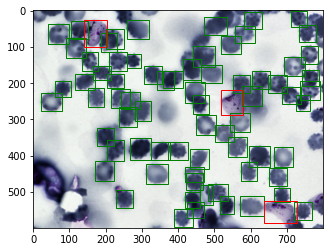

In [ ]:
show_sample(df.iloc[0].values)

In [ ]:
image = df["image"][0]
label = df["targets"][0]
plt.imshow(image)
print(label)

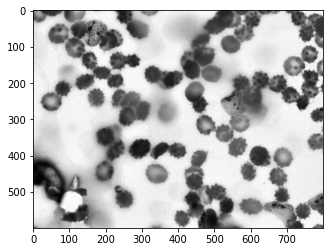

In [ ]:
gray_image = rgb2gray(image)
plt.imshow(gray_image, cmap=mpl.cm.gray)

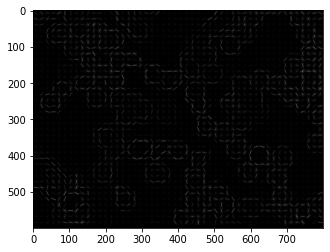

In [ ]:
# Histogram of oriented gradients
hog_features, hog_image = hog(gray_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)
plt.show()

In [ ]:
def create_features(images):
    hog_features = np.zeros((len(images), 136080))
    for i, image in enumerate(images): 
        gray_image = rgb2gray(image.numpy().transpose(1, 2, 0))
        hog_features[i] = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    return torch.tensor(hog_features)

def get_features(loader): 
    features = []
    for images, labels in loader: 
        features.append(create_features(images))
    return features

In [ ]:
# positive (0) if the sample contains infected cells
# negative (1) if the sample does not
def get_polarity(targets):
    for label in targets["labels"]: 
        if label.item() == 0: 
            return 0
    return 1

In [ ]:
count = 0
polarities = []
for i, (image, targets) in df.iterrows(): 
    polarity = get_polarity(targets)
    if polarity == 1:
        count+=1
    polarities.append(get_polarity(targets))
df["polarity"] = polarities
print(count)

192


In [ ]:
class PolarityDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image, targets, polarity = self.dataframe[index]
        if self.transform: 
            image = self.transform(image)
        return image, polarity

def get_loader(df, batch_size):
    dataset = PolarityDataset(df, transform = transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader

# Storing HOG Features and HOG Images

In [ ]:
hog_images = []
hog_features = []
for image in df["image"]:
    hog_feature, hog_image = hog(rgb2gray(image),
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
    hog_images.append(hog_image)
    hog_features.append(hog_feature)


# Store Labels

In [ ]:
labels = np.array(df["polarity"]).reshape(len(df["polarity"]),1)

In [ ]:
print(len(labels))
print(len(hog_features))

1328
1328


# Fitting to a simple SVM classifier

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
clf = svm.SVC()
hog_features = np.array(hog_features)
print(hog_features.shape)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)

(1328, 136080)


## Data Spliting

In [ ]:
#What percentage of data you want to keep for training
percentage = 80
partition = int(len(hog_features)*percentage/100)

x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

# Training

In [ ]:
clf.fit(x_train,y_train)

SVC()

# Testing

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.8571428571428571


              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       228
         1.0       0.00      0.00      0.00        38

    accuracy                           0.86       266
   macro avg       0.43      0.50      0.46       266
weighted avg       0.73      0.86      0.79       266



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---

